In [1]:
%config Completer.use_jedi = False

In [51]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mne
import json
import scipy.stats

# import scipy.io as sio
# from scipy import signal

import pac

import simple_pipeline

suffix = '_limited'#'_1ch_nv'
gamma = [20, 80]
beta  = [ 4, 16]

# functions

In [3]:
groups = ['PD Med Off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']

In [4]:
def plot_pac(pac, high_freq=gamma, low_freq=beta, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(7, 15))
        ax = fig.subplots()

    im = ax.imshow((pac), origin='lower', interpolation='nearest', 
                   extent=low_freq+high_freq,
#                    aspect='auto', )
                   aspect=np.diff(low_freq)/np.diff(high_freq), **kwargs)

    if ax is None:
        plt.show()
        
    return im

In [5]:
def get_percent(arr, thr=0.95):
    if arr.ndim > 1:
        arr = arr.ravel()
    freq, bins = np.histogram(arr, bins=100)
    return (
        bins[:-1][(freq / freq.sum()).cumsum() > thr][0], 
        bins[1:][(freq / freq.sum()).cumsum() > thr][0]
    )

In [6]:
def save_fig(path):
    directory = os.path.dirname(path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    plt.savefig(path)

# Create Task list in `tasks_df`

In [7]:
if __name__ == '__main__':
    tasks_df = simple_pipeline.create_tasks_df()
    
    completed = []
    for task in tasks_df.iloc:
        json_path = os.path.join(task['dir'], task['file_formatter'].format(f'completed{suffix}.json'))
        completed.append(os.path.exists(json_path))

    tasks_df = pd.concat([tasks_df, pd.DataFrame({'completed': completed})], axis=1)

# Load Data

In [9]:
groups = ['PD Med Off', 'PD Med On', 'CTL']
event_types = ['Target', 'Standard', 'Novelty']
mvl_2ds = [[] for k in groups] # np.zeros((3, 64, 169, 37))
mvls = [[] for k in groups] # np.zeros((3, 64))

for task in tasks_df.iloc:
# if 1:
    task_mvls = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'mvls{suffix}.npz')))
    task_mvl_2ds = np.load(os.path.join(task['dir'], task['file_formatter'].format(f'mvl_2ds{suffix}.npz')))

    nbchan = task_mvls[task_mvls.files[0]].shape[0]
    mvl = np.zeros((3, nbchan))
    for i, event_type in enumerate(sorted(task_mvls.files)):
        mvl[i] = task_mvls[event_type].diagonal()
        
    mvls[task.pd_drug_type].append(mvl)
    
    mvl_2d = np.zeros((3, nbchan, gamma[1] - gamma[0] + 1, beta[1] - beta[0] + 1))
    for i, event_type in enumerate(sorted(task_mvl_2ds.files)):
        mvl_2d[i] = task_mvl_2ds[event_type].diagonal(0, 0, 1).transpose((2, 0, 1))
        
    mvl_2ds[task.pd_drug_type].append(mvl_2d)

mvls = np.array(mvls)
mvl_2ds = np.array(mvl_2ds)

# Plot  2d PAC 

In [14]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
for ch in range(mvl_2ds.shape[3]):
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
    vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for i, j in itertools.product(range(3), range(3)):
        im = plot_pac(mvl_2ds[i, :, j, ch].mean(axis=0), ax=axs[i, j],
                      vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)

    save_fig(os.path.join('plots', f'pac{suffix}', f'pac_{channels[ch]}{suffix}'))
    plt.close(fig)

#     plt.show()

In [63]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
for ch in range(mvl_2ds.shape[3]):
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
#     vmin, vmax = get_percent(np.log(mvl_2ds[:, :, :, ch].mean(axis=1)), 0.83)
    for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
        a, b = grp[0]
        i = grp[1]
        t, p = scipy.stats.ttest_ind(mvl_2ds[a, :, j, ch], mvl_2ds[b, :, j, ch])
        p[p>0.05] = 1
        im = plot_pac(-np.log(p), ax=axs[i, j], )
#                       vmin=vmin, vmax=vmax)
        axs[i, j].xaxis.set_visible(False)
        axs[i, j].yaxis.set_visible(False)


    # fig.colorbar(im, ax=axs.ravel().tolist(), location='right', shrink=0.95)
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    # cbar = fig.colorbar(ims[i][j], ax=axs.ra//vel().tolist(), shrink=0.95)

    for grp in zip(itertools.combinations(range(3), 2), range(3)):
        a, b = grp[0]
        i = grp[1]
        
        axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)

    save_fig(os.path.join('plots', f'pac_pv{suffix}', f'pac_pv_{channels[ch]}{suffix}'))
    plt.close(fig)

#     plt.show()

# Plot topographic PAC

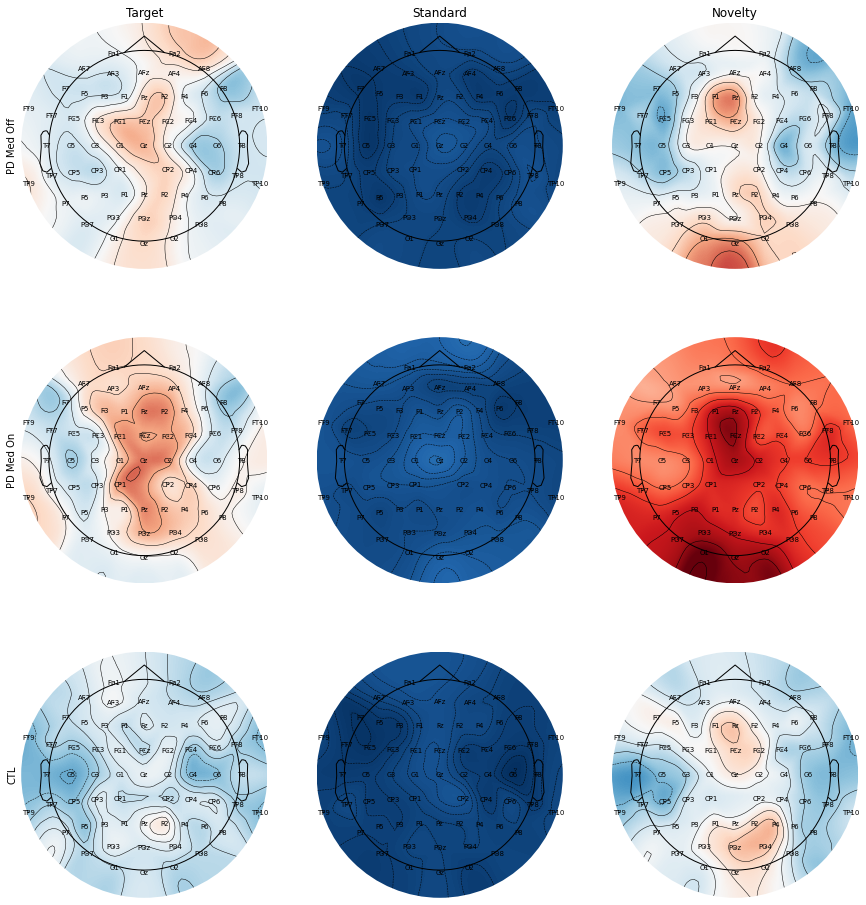

In [33]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
if 'VEOG' in channels: channels.remove('VEOG')

create_elc_file(task)
montage = mne.channels.read_custom_montage(os.path.join(
    task.dir, task.file_formatter.format('electrodes.elc')))

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
n_channels = mvls.shape[-1]
mne_info = mne.create_info(ch_names=channels, sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
vmin, vmax = mvls.mean(axis=1).min(), mvls.mean(axis=1).max() #get_percent(mvls.mean(axis=1), 0.95)
for i, j in itertools.product(range(3), range(3)):
    data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(data - mvls.mean(), mne_info)
    mvl_evoked.set_montage(montage)
    mne.viz.plot_topomap(mvl_evoked.data[:, 0], mvl_evoked.info, axes=axs[i, j], show=False,
                         names=channels, show_names=True, vmin=vmin- mvls.mean(), vmax=vmax- mvls.mean())

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        
# mne.viz.mne_analyze_colormap(limits=[vmin, (vmin+vmax)/2, vmax], format='mayavi')

plt.show()


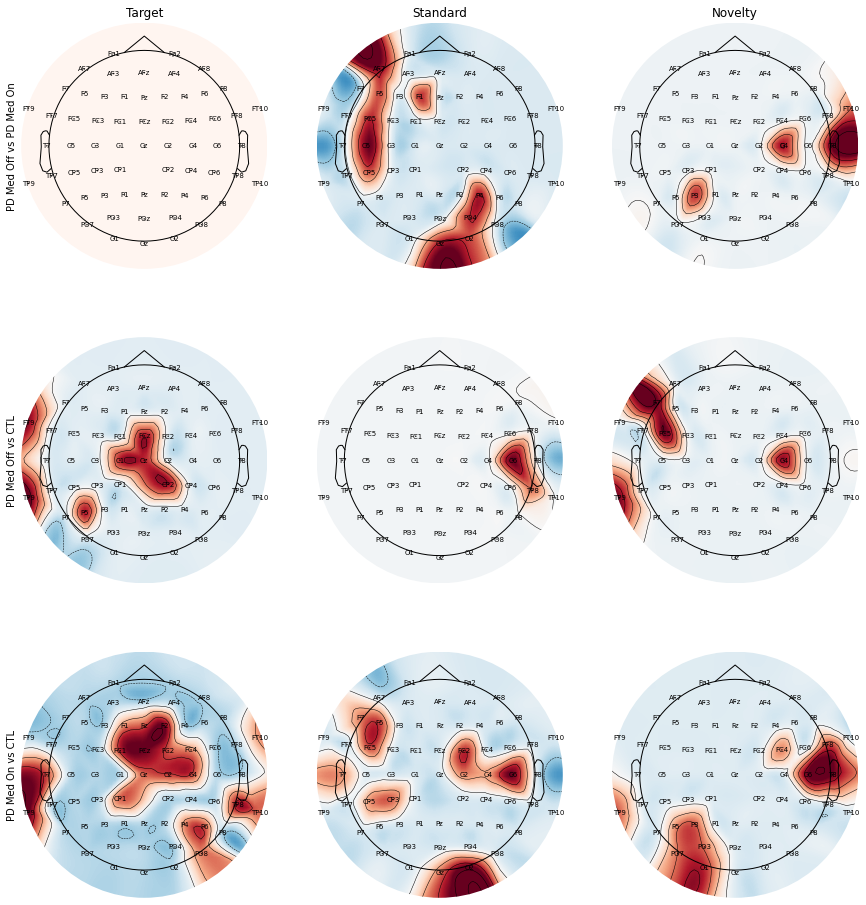

In [70]:
with open('config.json') as f:
    config = json.load(f)
    channels = config['channels']
    
if 'VEOG' in channels: channels.remove('VEOG')

create_elc_file(task)
montage = mne.channels.read_custom_montage(os.path.join(
    task.dir, task.file_formatter.format('electrodes.elc')))

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')
n_channels = mvls.shape[-1]
mne_info = mne.create_info(ch_names=channels, sfreq=500., ch_types='eeg')

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))
# vmin, vmax = mvls.mean(axis=1).min(), mvls.mean(axis=1).max() #get_percent(mvls.mean(axis=1), 0.95)
for grp, j in itertools.product(zip(itertools.combinations(range(3), 2), range(3)), range(3)):
    a, b = grp[0]
    i = grp[1]
    t, p = scipy.stats.ttest_ind(mvls[a, :, j, :], mvls[b, :, j, :])
    p[p>0.05] = 1
    p = p.reshape((-1, 1))
    mvl_evoked = mne.EvokedArray(-np.log(p) - -np.log(p).mean(), mne_info)
    mvl_evoked.set_montage(montage)
    mne.viz.plot_topomap(mvl_evoked.data[:, 0], mvl_evoked.info, axes=axs[i, j], show=False,
                         names=channels, show_names=True)#, vmin=vmin- mvls.mean(), vmax=vmax- mvls.mean())

for grp in zip(itertools.combinations(range(3), 2), range(3)):
    a, b = grp[0]
    i = grp[1]

    axs[i, 0].set_ylabel(f'{groups[a]} vs {groups[b]}')
    axs[0, i].set_title(event_types[i])

    axs[-1, i].xaxis.set_visible(True)
    axs[i, 0].yaxis.set_visible(True)
        

plt.show()